# 2-2: Initial Tensorflow Exploration

New to 2-2:  
In this version we've added one-hot columns for each category of true positive (tp) and false positive (fp) per species, as well as an additional column ('ambient'), describing audio without categorical wildlife calls that will be available for later use.

# Imports

In [1]:
# ! pip install seaborn
# ! pip install librosa

In [2]:
# General imports
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from math import floor

In [3]:
# import librosa for audio processing
import librosa

# for displaying playback
import IPython.display as ipd

# STFT Imports
from scipy.signal import stft
from scipy.signal import istft


In [4]:
! python --version

Python 3.7.6


In [5]:
# not available for python 3.9.2 :(
# pip install -q tensorflow-io

In [6]:
# not available for python 3.9.2
# import tensorflow_io as tfio

In [7]:
# import tensorflow
import tensorflow as tf

# check version
tf.version.VERSION

'2.4.1'

In [8]:
# pip install -q pyyaml h5py

In [9]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

keras = tf.keras

# for displaying playback, et al
from IPython import display

# Seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [10]:
# System filepath setup
import sys

# add data, src and img folders to filepath
# add data folders to path
sys.path.insert(1, '../data')
sys.path.insert(1, '../src')
sys.path.insert(1, '../img')

# check local filepath

Reference:
- [How to train a Keras model on TFRecord files](https://keras.io/examples/keras_recipes/tfrecord/)

## Import Comprehnsive DataFrame

The `comprehensive_df` contains:
- tp and fp listings (time in/out, frequency min/max) for 24 species for each audio file


In [11]:
comprehensive_df = pd.read_pickle("../data/pickle_files/comprehensive_df_1-2.pkl")

In [12]:
print(comprehensive_df.shape)
comprehensive_df.head()

(8997, 57)


,recording_id,label_type,species_id,songtype_id,t_min,f_min,t_max,f_max,tp_0,tp_1,...,fp_15,fp_16,fp_17,fp_18,fp_19,fp_20,fp_21,fp_22,fp_23,ambient
0,003bec244,tp,14,1,44.5440,2531.250,45.1307,5531.25,0,0,...,0,0,0,0,0,0,0,0,0,0
1,006ab765f,tp,23,1,39.9615,7235.160,46.0452,11283.40,0,0,...,0,0,0,0,0,0,0,0,0,0
2,007f87ba2,tp,12,1,39.1360,562.500,42.2720,3281.25,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0099c367b,tp,17,4,51.4206,1464.260,55.1996,4565.04,0,0,...,0,0,0,0,0,0,0,0,0,0
4,009b760e6,tp,10,1,50.0854,947.461,52.5293,10852.70,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preparing Data: Selecting Species with calls shorter than 1 second

Species 1, 3, 14, 18 all have maximum tp call lengths of less then one second.

This will enable a consistent, 1 second window for the shortest sample sounds, while still enabling a multiclassification test.

In [13]:
sub_1_bool = (comprehensive_df['species_id'] == 1) | \
             (comprehensive_df['species_id'] == 3) | \
             (comprehensive_df['species_id'] == 14) | \
             (comprehensive_df['species_id'] == 18) 

          

In [14]:
sub_1_df = comprehensive_df[sub_1_bool]

In [15]:
sub_1_df

,recording_id,label_type,species_id,songtype_id,t_min,f_min,t_max,f_max,tp_0,tp_1,...,fp_15,fp_16,fp_17,fp_18,fp_19,fp_20,fp_21,fp_22,fp_23,ambient
0,003bec244,tp,14,1,44.5440,2531.25,45.1307,5531.25,0,0,...,0,0,0,0,0,0,0,0,0,0
7,011f25080,tp,18,1,5.6853,3187.50,6.3787,5062.50,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0151b7d20,tp,1,1,46.0320,3843.75,46.9280,5625.00,0,1,...,0,0,0,0,0,0,0,0,0,0
22,043356ff8,tp,18,1,0.1227,3187.50,0.8160,5062.50,0,0,...,0,0,0,0,0,0,0,0,0,0
27,050d0ca85,tp,3,1,49.9200,1031.25,50.6613,2812.50,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7764,ff858780b,fp,18,1,44.1760,3187.50,44.8693,5062.50,0,0,...,0,0,0,1,0,0,0,0,0,0
7773,ffd88cd84,fp,14,1,2.1547,2531.25,2.7413,5531.25,0,0,...,0,0,0,0,0,0,0,0,0,0
7776,ffd88cd84,fp,14,1,3.2000,2531.25,3.7867,5531.25,0,0,...,0,0,0,0,0,0,0,0,0,0
7777,ffebe7313,fp,1,1,35.2000,3843.75,36.0960,5625.00,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
sub_1_df.iloc[0]

recording_id    003bec244
label_type             tp
species_id             14
songtype_id             1
t_min              44.544
f_min             2531.25
t_max             45.1307
f_max             5531.25
tp_0                    0
tp_1                    0
tp_2                    0
tp_3                    0
tp_4                    0
tp_5                    0
tp_6                    0
tp_7                    0
tp_8                    0
tp_9                    0
tp_10                   0
tp_11                   0
tp_12                   0
tp_13                   0
tp_14                   1
tp_15                   0
tp_16                   0
tp_17                   0
tp_18                   0
tp_19                   0
tp_20                   0
tp_21                   0
tp_22                   0
tp_23                   0
fp_0                    0
fp_1                    0
fp_2                    0
fp_3                    0
fp_4                    0
fp_5                    0
fp_6        

In [17]:
# relative filepath to local flac audio files
! ls ../data/rfcx-species-audio-detection/train

00204008d.flac 32326a03d.flac 657339fdd.flac 9996f3de8.flac ce05b264d.flac
003b04435.flac 32464c219.flac 65971c0e7.flac 999bac2e2.flac ce0c22f8a.flac
003bec244.flac 3267e79e6.flac 65bcc9ad4.flac 99a3e9c18.flac ce1787eaa.flac
005f1f9a5.flac 326992b55.flac 65daa4d4d.flac 99aa327b4.flac ce332f2fa.flac
006ab765f.flac 3292bbae4.flac 65f32be6d.flac 99ad8ec2e.flac ce4002d4e.flac
0072f0839.flac 3296a3827.flac 660604c58.flac 99b8ad978.flac ce46ce19d.flac
0079ff47b.flac 32af58c85.flac 6606e8d7e.flac 99dac3985.flac ce4a422fa.flac
007f87ba2.flac 32c0ebf77.flac 6645f0d5d.flac 99ece8c7f.flac ce5b205f3.flac
00834f88e.flac 32cf84e6f.flac 664a8e8e5.flac 99efe9a99.flac ce66ba21f.flac
008c9c381.flac 32e42c4fb.flac 664ed0511.flac 99f72cf18.flac ce7273ce3.flac
0099c367b.flac 32ea5e03e.flac 6666e213d.flac 9a18a1177.flac ce7f36db6.flac
009aa1c8f.flac 32f8c551e.flac 666dd7d48.flac 9a33fd3e2.flac ce82507b3.flac
009b760e6.flac 3346f84ee.flac 667b7363f.flac 9a390abd3.flac ce8270c7b.flac
009fbc7b4.flac 338107119.

## Function: Get Filepath

In [18]:
def get_filepath(given_recording_id, local_filepath='../data/rfcx-species-audio-detection/train/', type='flac'):
    return f'{local_filepath}{str(given_recording_id)}.{type}'

## Function: Get Audio 1d Numpy Array

In [19]:
def get_audio_np(index, sr=48000, duration=1):
    
    r_id = index['recording_id']
    
    f_path = get_filepath(r_id)
    
    t_min_floor = floor(index['t_min'])
    
    audio_np_arr = librosa.load(path=f_path,
                                sr=sr,
                                offset=test_offset,
                                duration=duration)[0]
    return audio_np_arr
    

In [20]:
test_rec_id = sub_1_df.iloc[0]['recording_id']
test_path = get_filepath(test_rec_id)

print(type(test_path), test_path)

<class 'str'> ../data/rfcx-species-audio-detection/train/003bec244.flac


In [21]:
test_offset = floor(sub_1_df.iloc[0]['t_min'])


# typically load generates a tuple with the 1d np array and the sample rate (sr)
# we only need the np array
one_sec = librosa.load(path=test_path,
                      sr=48000,
                      offset=test_offset,
                      duration=1)[0]

In [22]:
print(type(one_sec))
print(one_sec.shape)
ipd.Audio(one_sec, rate=48000)

<class 'numpy.ndarray'>
(48000,)


## Create audio_np column & audio array

We'll be creating one of each to check for compatibility later

In [23]:
sub_1_df.insert(loc=1, column='audio_np_1d', value=sub_1_df.apply(lambda x: get_audio_np(x), axis='columns'))

sub_1_np_arr = np.array(sub_1_df.apply(lambda x: get_audio_np(x), axis='columns'))

In [24]:
print(sub_1_df['audio_np_1d'].shape[0])


print(sub_1_np_arr.shape[0]) # 1398 entries

print(sub_1_np_arr[0].shape) # 48000 samples each; 1 min of audio

1398
1398
(48000,)


## Create audio_np column for comprehensive_df

Currently, this will only give the first second of audio for longer audio samples...

In [25]:
%%time
comprehensive_df.insert(loc=1, column='audio_np_1d', value=comprehensive_df.apply(lambda x: get_audio_np(x), axis='columns'))

CPU times: user 9.44 s, sys: 1.78 s, total: 11.2 s
Wall time: 14.8 s


# STFT

## Compare scipy stft and lib_stft outputs

In [26]:
lib_stft = librosa.stft(sub_1_df.iloc[0]['audio_np_1d'])
lib_stft.shape

(1025, 94)

In [27]:
# stft typically returns f (frequency), t (time), and Zxx(n-dim stft matrix)
_Zxx = stft(sub_1_df.iloc[0]['audio_np_1d'],
                    fs=48000)[2]

In [28]:
_Zxx.shape

(129, 376)

In [29]:
print((1025 * 94)) # lib_stft shape (quite a bit larger...)
print(129 * 376) # scipy stft shape

96350
48504


## Create STFT column using SciPy

In [30]:
sub_1_df.insert(loc=2, column='stft_scipy', value=sub_1_df['audio_np_1d'].apply(lambda x: stft(x, fs=48000)[2]))

In [31]:
sub_1_df.columns

Index(['recording_id', 'audio_np_1d', 'stft_scipy', 'label_type', 'species_id',
       'songtype_id', 't_min', 'f_min', 't_max', 'f_max', 'tp_0', 'tp_1',
       'tp_2', 'tp_3', 'tp_4', 'tp_5', 'tp_6', 'tp_7', 'tp_8', 'tp_9', 'tp_10',
       'tp_11', 'tp_12', 'tp_13', 'tp_14', 'tp_15', 'tp_16', 'tp_17', 'tp_18',
       'tp_19', 'tp_20', 'tp_21', 'tp_22', 'tp_23', 'fp_0', 'fp_1', 'fp_2',
       'fp_3', 'fp_4', 'fp_5', 'fp_6', 'fp_7', 'fp_8', 'fp_9', 'fp_10',
       'fp_11', 'fp_12', 'fp_13', 'fp_14', 'fp_15', 'fp_16', 'fp_17', 'fp_18',
       'fp_19', 'fp_20', 'fp_21', 'fp_22', 'fp_23', 'ambient'],
      dtype='object')

## Create STFT column for Comprehensive

In [32]:
comprehensive_df.insert(loc=2, column='stft_scipy', value=comprehensive_df['audio_np_1d'].apply(lambda x: stft(x, fs=48000)[2]))

# Preparing Data: Test Train Split

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
oh_col_headings = comprehensive_df.loc[:,'tp_0':'ambient'].columns
print(len(oh_col_headings))
print(oh_col_headings)

49
Index(['tp_0', 'tp_1', 'tp_2', 'tp_3', 'tp_4', 'tp_5', 'tp_6', 'tp_7', 'tp_8',
       'tp_9', 'tp_10', 'tp_11', 'tp_12', 'tp_13', 'tp_14', 'tp_15', 'tp_16',
       'tp_17', 'tp_18', 'tp_19', 'tp_20', 'tp_21', 'tp_22', 'tp_23', 'fp_0',
       'fp_1', 'fp_2', 'fp_3', 'fp_4', 'fp_5', 'fp_6', 'fp_7', 'fp_8', 'fp_9',
       'fp_10', 'fp_11', 'fp_12', 'fp_13', 'fp_14', 'fp_15', 'fp_16', 'fp_17',
       'fp_18', 'fp_19', 'fp_20', 'fp_21', 'fp_22', 'fp_23', 'ambient'],
      dtype='object')


## Subset train test split

In [35]:
sub_X_train, sub_X_test, sub_y_train, sub_y_test = train_test_split(sub_1_df['stft_scipy'], sub_1_df[oh_col_headings],
                                                                    test_size= 0.15,
                                                                    random_state=42, 
                                                                    stratify=sub_1_df[oh_col_headings])
                                                                    

In [36]:
print(len(sub_y_train), len(sub_X_train))
print(len(sub_y_test), len(sub_X_test))

1188 1188
210 210


In [37]:
print(sub_X_train.iloc[0].shape)
sub_X_train.head()

(129, 376)


880     [[(-0.00033471285+0j), (0.0013436021+0j), (-0....
4228    [[(0.00023320985+0j), (0.0011699791+0j), (0.00...
1686    [[(4.6379675e-05+0j), (-0.0011179334+0j), (-0....
581     [[(0.0013610503+0j), (0.0005167178+0j), (-0.00...
110     [[(-0.012035766+0j), (0.047459234+0j), (0.1135...
Name: stft_scipy, dtype: object

In [38]:
print(sub_y_train.iloc[0].shape)
print(sub_y_train.shape)
sub_y_train.head()

(49,)
(1188, 49)


,tp_0,tp_1,tp_2,tp_3,tp_4,tp_5,tp_6,tp_7,tp_8,tp_9,...,fp_15,fp_16,fp_17,fp_18,fp_19,fp_20,fp_21,fp_22,fp_23,ambient
880,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# each should be consistently shaped...
for i in range(5):
    print(sub_X_train.iloc[i].shape)

(129, 376)
(129, 376)
(129, 376)
(129, 376)
(129, 376)


# Comprehensive Train Test Split

In [40]:
comp_X_train, comp_X_test, comp_y_train, comp_y_test = train_test_split(comprehensive_df['stft_scipy'], comprehensive_df[oh_col_headings],
                                                                    test_size= 0.15,
                                                                    random_state=42, 
                                                                    stratify=comprehensive_df[oh_col_headings])

## Ensure a format that tensorflow will read successfully

In [41]:
# note to self:

# test_x = sub_X_train.apply(lambda x: x.reshape(1, 129, -1))
# text_y = sub_y_train.apply(lambda x: x.to_numpy().reshape(1, 24))

In [42]:
# ensure a format that tensorflow will read successfully

# training set
# sub_X_train.iloc[0]
np.array(sub_X_train.to_list()).shape

sub_X_train_np_arr = np.array(sub_X_train.to_list())
print(sub_X_train_np_arr.shape)


# test set
# sub_X_test.iloc[0]
np.array(sub_X_test.to_list()).shape

sub_X_test_np_arr = np.array(sub_X_test.to_list())
print(sub_X_test_np_arr.shape)


# training set
# sub_X_train.iloc[0]
np.array(comp_X_train.to_list()).shape

comp_X_train_np_arr = np.array(comp_X_train.to_list())
print(comp_X_train_np_arr.shape)


# test set
# sub_X_test.iloc[0]
np.array(comp_X_test.to_list()).shape

comp_X_test_np_arr = np.array(comp_X_test.to_list())
print(comp_X_test_np_arr.shape)



(1188, 129, 376)
(210, 129, 376)
(7647, 129, 376)
(1350, 129, 376)


# Tensorflow

Resources

- [Categorical Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)  
- [Label Ranking Average Precision](https://scikit-learn.org/stable/modules/model_evaluation.html#label-ranking-average-precision)  

"Label Weighted"
https://www.kaggle.com/c/rfcx-species-audio-detection/overview/evaluation



# CNN Model

Resources:
- [Simple Audio](https://www.tensorflow.org/tutorials/audio/simple_audio)
- [TensorFlow: Save and Load](https://www.tensorflow.org/tutorials/keras/save_and_load)  

## Create Checkpoints

In [43]:
ls ../data/checkpoints

training_1/


In [44]:
checkpoint_path = "../data/checkpoints/training_1/cnn_1-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Callback to save model's weights
cp_callback =tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

## Create Model (model_cnn_1)

In [45]:
model_cnn_1 = tf.keras.Sequential()

model_cnn_1.add(keras.layers.Flatten(input_shape=(129, 376)))
print(model_cnn_1.output_shape)

# dense layers...
model_cnn_1.add(keras.layers.Dense(512, activation='relu'))

model_cnn_1.add(keras.layers.Dense(64, activation='relu'))

model_cnn_1.add(keras.layers.Dense(49, activation='softmax'))

model_cnn_1.summary()

(None, 48504)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 48504)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               24834560  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 49)                3185      
Total params: 24,870,577
Trainable params: 24,870,577
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_cnn_1.compile(optimizer='Adam', 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [47]:
cnn_1_history = model_cnn_1.fit(x=comp_X_train_np_arr, 
                                y=comp_y_train,
#                               validation_split=0.15,
                                validation_data=(comp_X_test_np_arr, comp_y_test),
                                callbacks=cp_callback,
                                epochs=1000)

Epoch 1/1000
239/239 [==============================] - 32s 129ms/step - loss: 3.7207 - accuracy: 0.0534 - val_loss: 3.5559 - val_accuracy: 0.0681

Epoch 00001: val_loss improved from inf to 3.55591, saving model to ../data/checkpoints/training_1/cnn_1-0001.ckpt
Epoch 2/1000
239/239 [==============================] - 28s 117ms/step - loss: 3.4197 - accuracy: 0.1013 - val_loss: 3.5819 - val_accuracy: 0.0763

Epoch 00002: val_loss did not improve from 3.55591
Epoch 3/1000
239/239 [==============================] - 25s 106ms/step - loss: 3.1949 - accuracy: 0.1692 - val_loss: 3.6603 - val_accuracy: 0.0793

Epoch 00003: val_loss did not improve from 3.55591
Epoch 4/1000
239/239 [==============================] - 26s 108ms/step - loss: 2.8454 - accuracy: 0.2514 - val_loss: 3.8601 - val_accuracy: 0.0815

Epoch 00004: val_loss did not improve from 3.55591
Epoch 5/1000
239/239 [==============================] - 25s 104ms/step - loss: 2.4999 - accuracy: 0.3258 - val_loss: 4.0893 - val_accuracy: 

### Check Training Predictions vs. Training Labels

As the model is trained on these, they should be perfect (or at least pretty close)

In [48]:
label_names = comp_y_test.idxmax(axis='columns')
# label_number = sub_y_test.columns.get_loc('tp_20')

label_number_list = list((comp_y_test.columns.get_loc(x) for x in label_names))

In [49]:
pred_train = model_cnn_1.predict_classes(comp_X_train_np_arr, verbose=1)

  1/239 [..............................] - ETA: 36s

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


239/239 [==============================] - 5s 20ms/step


In [50]:
comp_y_train.idxmax(axis=1)

243      fp_8
3614     fp_2
6885    fp_18
959      fp_8
225      tp_2
        ...  
1614    fp_23
7095    fp_17
6667     fp_0
3470    fp_20
5501    fp_14
Length: 7647, dtype: object

In [51]:
for i in zip(pred_train, label_number_list, comp_y_train):

    print(f'predicted: {i[0]:2} ({list(comp_y_test.columns)[i[0]]:6}), {i[1]}, {i[2]}')

predicted: 32 (fp_8  ), 38, tp_0
predicted: 47 (fp_23 ), 34, tp_1
predicted: 42 (fp_18 ), 40, tp_2
predicted: 32 (fp_8  ), 41, tp_3
predicted:  2 (tp_2  ), 25, tp_4
predicted: 42 (fp_18 ), 40, tp_5
predicted: 41 (fp_17 ), 29, tp_6
predicted: 28 (fp_4  ), 46, tp_7
predicted: 28 (fp_4  ), 30, tp_8
predicted: 47 (fp_23 ), 28, tp_9
predicted:  8 (tp_8  ), 23, tp_10
predicted: 41 (fp_17 ), 41, tp_11
predicted: 33 (fp_9  ), 44, tp_12
predicted: 44 (fp_20 ), 35, tp_13
predicted: 47 (fp_23 ), 41, tp_14
predicted: 28 (fp_4  ), 42, tp_15
predicted: 41 (fp_17 ), 28, tp_16
predicted: 43 (fp_19 ), 7, tp_17
predicted: 17 (tp_17 ), 45, tp_18
predicted: 34 (fp_10 ), 32, tp_19
predicted: 31 (fp_7  ), 46, tp_20
predicted: 44 (fp_20 ), 28, tp_21
predicted: 32 (fp_8  ), 36, tp_22
predicted: 41 (fp_17 ), 35, tp_23
predicted: 37 (fp_13 ), 35, fp_0
predicted: 14 (tp_14 ), 25, fp_1
predicted: 47 (fp_23 ), 20, fp_2
predicted: 40 (fp_16 ), 34, fp_3
predicted: 37 (fp_13 ), 40, fp_4
predicted: 38 (fp_14 ), 46, fp

### Check Against Test Train Split Test set

Resources: 
- [Get Column Index from Column Name (Pandas)](https://stackoverflow.com/a/13021797)  


In [52]:
pred_test = model_cnn_1.predict_classes(comp_X_test_np_arr, verbose=1)

for i in zip(pred_test, label_number_list):

    print(f'predicted: {i[0]:2}, actual: {i[1]:2}')

43/43 [==============================] - 1s 19ms/step
predicted: 10, actual: 38
predicted: 47, actual: 34
predicted: 41, actual: 40
predicted: 36, actual: 41
predicted: 27, actual: 25
predicted: 27, actual: 40
predicted: 37, actual: 29
predicted: 16, actual: 46
predicted: 41, actual: 30
predicted:  8, actual: 28
predicted: 33, actual: 23
predicted: 25, actual: 41
predicted: 30, actual: 44
predicted: 10, actual: 35
predicted: 30, actual: 41
predicted: 27, actual: 42
predicted: 10, actual: 28
predicted: 35, actual:  7
predicted: 28, actual: 45
predicted: 41, actual: 32
predicted: 28, actual: 46
predicted: 31, actual: 28
predicted: 37, actual: 36
predicted: 31, actual: 35
predicted: 46, actual: 35
predicted: 47, actual: 25
predicted: 10, actual: 20
predicted: 27, actual: 34
predicted: 32, actual: 40
predicted: 17, actual: 46
predicted: 47, actual: 47
predicted: 33, actual: 35
predicted: 47, actual: 46
predicted: 27, actual:  3
predicted: 25, actual: 26
predicted: 41, actual: 41
predicted:

# Confusion Matrix

Resources:

- [Plot Confusion Matrix (Scikit-Learn)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) 
- [Tensorflow Sample Confusion Matrix](https://www.tensorflow.org/tutorials/audio/simple_audio)  

In [53]:
pred_test

array([10, 47, 41, ..., 43, 33, 38])

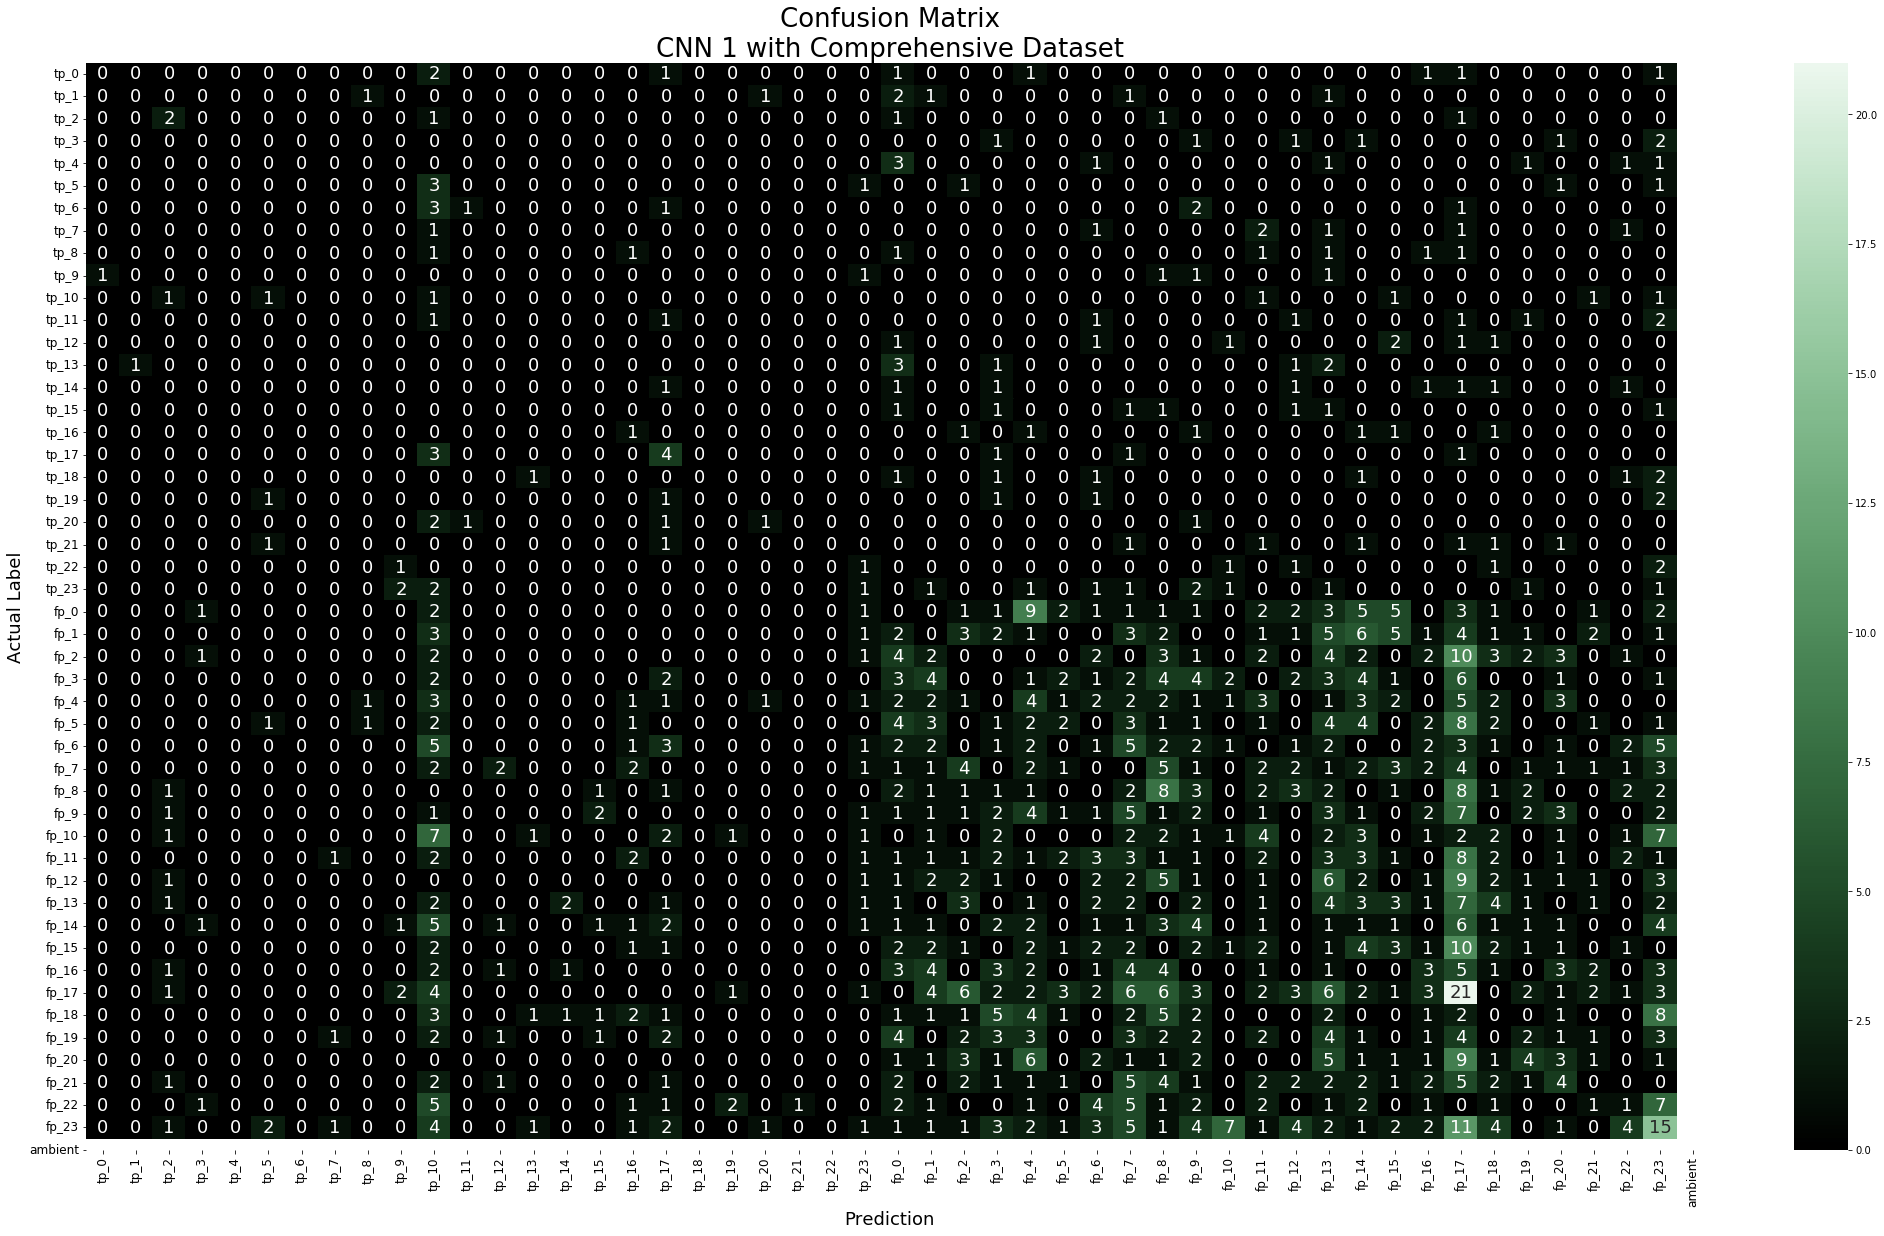

In [68]:
confusion_mtx = tf.math.confusion_matrix(label_number_list, pred_test) 
plt.figure(figsize=(36, 20))

# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True
    
gr_cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
    
sns.heatmap(confusion_mtx, 
            xticklabels=sub_y_train.columns, 
            yticklabels=sub_y_train.columns,
            annot=True, 
            cmap=gr_cmap,
            fmt='g',
            annot_kws={"fontsize": 18})
plt.title('Confusion Matrix\nCNN 1 with Comprehensive Dataset', fontsize=26)

plt.xlabel('Prediction', fontsize=18)
plt.ylabel('Actual Label', fontsize=18)
plt.xticks(ha='center', fontsize=12)
plt.yticks(va='center', fontsize=12)

# plt.savefig('../img/comp_1_1000/confusion_matrix_model_cnn_comp_1_1000',
#             bbox_inches='tight')

plt.show()

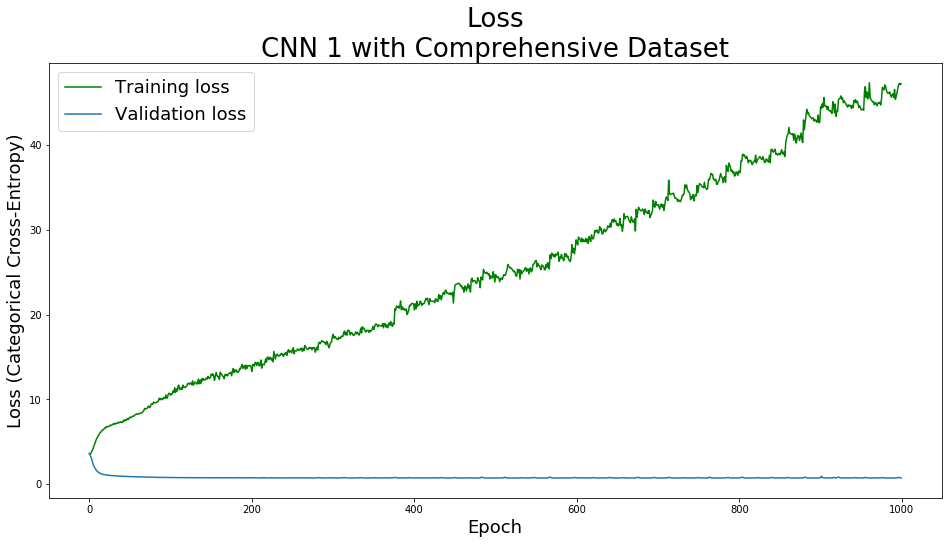

In [72]:
metrics = cnn_1_history.history

plt.figure(figsize=(16, 8))
# plt.plot(cnn_sub_2_history.epoch, metrics['loss'], metrics['val_loss'])

plt.plot(cnn_1_history.epoch, metrics['val_loss'], color='g')
plt.plot(cnn_1_history.epoch, metrics['loss'])

plt.title('Loss\nCNN 1 with Comprehensive Dataset', fontsize=26)
plt.legend(['Training loss', 'Validation loss'], fontsize=18)
plt.ylabel('Loss (Categorical Cross-Entropy)', fontsize=18)
plt.xlabel('Epoch', fontsize=18)


# plt.savefig('../img/comp_1_1000/loss_model_cnn_comp_1_1000',
#             bbox_inches='tight')
plt.show()

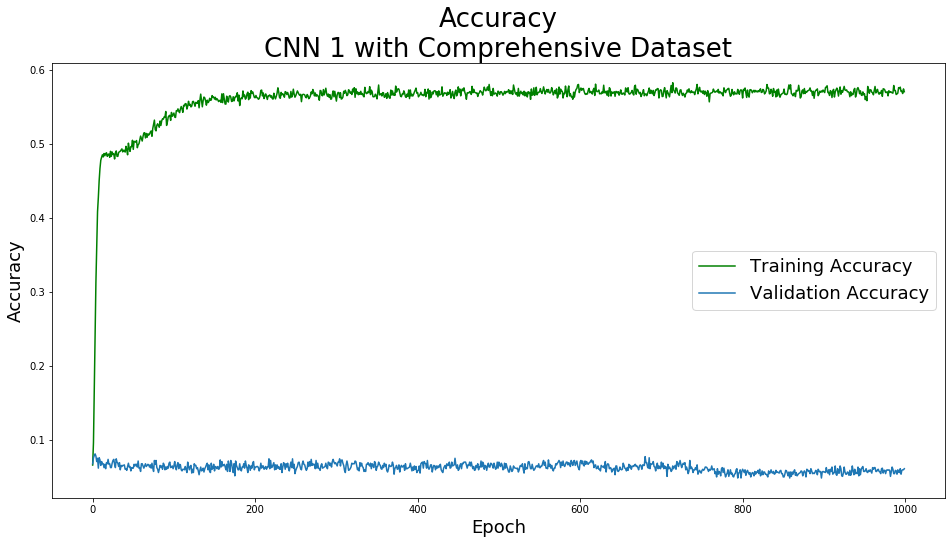

In [73]:
metrics = cnn_1_history.history

plt.figure(figsize=(16, 8))
plt.plot(cnn_1_history.epoch, metrics['accuracy'], color='g')
plt.plot(cnn_1_history.epoch, metrics['val_accuracy'])


plt.title('Accuracy\nCNN 1 with Comprehensive Dataset', fontsize=26)

plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)


# plt.savefig('../img/comp_1_1000/accuracy_model_cnn_comp_1_1000',
#             bbox_inches='tight')
plt.show()

In [56]:
sub_X_test.iloc[0]
np.array(sub_X_test.to_list()).shape

sub_X_test_np_arr = np.array(sub_X_test.to_list())
sub_X_test_np_arr.shape

(210, 129, 376)

In [57]:
pred_test_cnn_1 = model_cnn_1.predict_classes(sub_X_test_np_arr, verbose=1)

for i in zip(pred_test_cnn_1, sub_y_test.idxmax(axis="columns")):

    print(i)

7/7 [==============================] - 0s 16ms/step
(25, 'fp_1')
(38, 'fp_14')
(41, 'fp_18')
(41, 'fp_14')
(27, 'fp_14')
(42, 'fp_18')
(42, 'fp_18')
(25, 'fp_1')
(42, 'fp_18')
(38, 'fp_14')
(35, 'fp_3')
(19, 'fp_3')
(41, 'fp_18')
(30, 'fp_1')
(25, 'fp_1')
(25, 'fp_18')
(37, 'fp_1')
(27, 'fp_3')
(28, 'fp_18')
(32, 'fp_14')
(27, 'fp_3')
(32, 'fp_14')
(38, 'fp_14')
(30, 'fp_14')
(24, 'tp_14')
(27, 'fp_3')
(38, 'fp_14')
(35, 'fp_3')
(33, 'fp_3')
(25, 'fp_1')
(27, 'fp_3')
(31, 'fp_14')
(25, 'fp_1')
(47, 'fp_18')
(42, 'fp_18')
(18, 'tp_18')
(25, 'fp_1')
(38, 'fp_14')
(41, 'tp_3')
(28, 'fp_18')
(3, 'tp_3')
(38, 'fp_14')
(32, 'fp_3')
(27, 'fp_3')
(42, 'fp_18')
(39, 'fp_3')
(39, 'fp_18')
(38, 'fp_14')
(25, 'fp_3')
(41, 'fp_3')
(42, 'fp_18')
(29, 'fp_18')
(33, 'tp_3')
(32, 'fp_18')
(25, 'fp_1')
(36, 'fp_14')
(20, 'tp_1')
(42, 'fp_14')
(24, 'fp_3')
(24, 'tp_18')
(24, 'fp_1')
(25, 'fp_1')
(30, 'fp_18')
(24, 'tp_3')
(38, 'fp_14')
(47, 'fp_18')
(25, 'fp_3')
(38, 'fp_1')
(41, 'fp_1')
(27, 'fp_18')
(1

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# Save model_cnn_1

In [58]:
# ls ../data/saved_models

# model_cnn_1.save('../data/saved_models/cnn_1_1000_epochs')

INFO:tensorflow:Assets written to: ../data/saved_models/cnn_1_1000_epochs/assets


# CNN 2

In [60]:
model_cnn_2.compile(optimizer='Adam', 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [61]:
# cnn_2_history = model_cnn_2.fit(x=sub_X_np_arr, 
#                             y=sub_y_train,
#                             validation_split=0.1,
#                             epochs=1)

In [62]:
# pred_test_cnn_2 = model_cnn_1.predict_classes(sub_X_test_np_arr, verbose=1)

# # pred_test_cnn_2 = np.argmax(model_cnn_1.predict_classes(sub_X_test_np_arr, verbose=1), axis=-1) 

# # print (pred_test_cnn_2)
# for i in zip(pred_test_cnn_2, sub_y_test.idxmax(axis="columns")):

#     print(i)

In [63]:
1 / (49) ** 0.5

0.14285714285714285